# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from datetime import datetime


print("All previous libraries are imported correctly!")

All previous libraries are imported correctly!


### DOWNLOAD HTML

In [2]:
# We specify the url we want to scrape:
url = 'https://ycharts.com/companies/TSLA/revenues'

# Headers para simular una solicitud desde un navegador real [NOS SALÍA ERROR 403]
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1'
}

try:
    # Hacemos la solicitud HTTP GET con los headers
    response = requests.get(url, headers=headers)

    # Verificamos el código de estado de la respuesta
    if response.status_code == 200:
        print("Acceso exitoso!")
    else:
        print(f"No hemos podido acceder, nos sale el error: {response.status_code}")
except Exception as e:
    print(f"Ocurrió un error: {e}")

Acceso exitoso!


In [3]:
response = requests.get(url, headers=headers)
content = response.content

soup = BeautifulSoup(content, 'html.parser')

soup


<!DOCTYPE html>

<html lang="en" ng-jq="">
<head>
<title>
        Tesla Revenue (Quarterly) Analysis | YCharts
        </title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<!-- This code allows us to correctly display the page on mobile devices -->
<script defer="">
    var viewport = document.querySelector('meta[name=viewport]');
    if (viewport) {
        var minWidth = 700;
        if (screen.width < minWidth) {
            document.head.removeChild(viewport);
            var newViewport = document.createElement('meta');
            newViewport.setAttribute('name', 'viewport');
            newViewport.setAttribute('content', 'width=' + minWidth);
            document.head.appendChild(newViewport);
        }
    }
</script>
<script>
    if (navigator.userAgent.indexOf('Trident') !== -1 || navigator.userAgent.indexOf('MSIE') !== -1) {
        window.onload=function() {
            var ie_banner = document.createElement('div');
            ie_banner.innerT

In [5]:
# We create a list to store the information from the tables we are interested in.
table_data = [] 


# We create a forloop to find the tables with the data we are interested in. We found a pattern in the tables we want, with <thead>, <tbody> and the text Date.
for table in soup.find_all('table', class_='table'):
    # We check if the pattern is there.
    if table.find('thead') and 'Date' in table.find('thead').get_text() and 'Value' in table.find('thead').get_text():
        # We extract the data from the rows.
        rows = table.find('tbody').find_all('tr')
        # We extract the data from the rows.
        for row in rows:
            # We extract the <td> information.
            cells = row.find_all('td')
            # We check we received both items of information.
            if len(cells) == 2:
                table_data.append([cell.get_text(strip = True) for cell in cells])

print(table_data)

[['June 30, 2024', '25.50B'], ['March 31, 2024', '21.30B'], ['December 31, 2023', '25.17B'], ['September 30, 2023', '23.35B'], ['June 30, 2023', '24.93B'], ['March 31, 2023', '23.33B'], ['December 31, 2022', '24.32B'], ['September 30, 2022', '21.45B'], ['June 30, 2022', '16.93B'], ['March 31, 2022', '18.76B'], ['December 31, 2021', '17.72B'], ['September 30, 2021', '13.76B'], ['June 30, 2021', '11.96B'], ['March 31, 2021', '10.39B'], ['December 31, 2020', '10.74B'], ['September 30, 2020', '8.771B'], ['June 30, 2020', '6.036B'], ['March 31, 2020', '5.985B'], ['December 31, 2019', '7.384B'], ['September 30, 2019', '6.303B'], ['June 30, 2019', '6.35B'], ['March 31, 2019', '4.541B'], ['December 31, 2018', '7.226B'], ['September 30, 2018', '6.824B'], ['June 30, 2018', '4.002B'], ['March 31, 2018', '3.409B'], ['December 31, 2017', '3.288B'], ['September 30, 2017', '2.985B'], ['June 30, 2017', '2.790B'], ['March 31, 2017', '2.696B'], ['December 31, 2016', '2.285B'], ['September 30, 2016', '2.

In [6]:
# Becasue I know there is only two headers needed, I will manually add the headers.
headers = ['Date', 'Value']


# We create the DataFrame from the data list.
df = pd.DataFrame(table_data, columns=headers)


print(df)

                  Date    Value
0        June 30, 2024   25.50B
1       March 31, 2024   21.30B
2    December 31, 2023   25.17B
3   September 30, 2023   23.35B
4        June 30, 2023   24.93B
5       March 31, 2023   23.33B
6    December 31, 2022   24.32B
7   September 30, 2022   21.45B
8        June 30, 2022   16.93B
9       March 31, 2022   18.76B
10   December 31, 2021   17.72B
11  September 30, 2021   13.76B
12       June 30, 2021   11.96B
13      March 31, 2021   10.39B
14   December 31, 2020   10.74B
15  September 30, 2020   8.771B
16       June 30, 2020   6.036B
17      March 31, 2020   5.985B
18   December 31, 2019   7.384B
19  September 30, 2019   6.303B
20       June 30, 2019    6.35B
21      March 31, 2019   4.541B
22   December 31, 2018   7.226B
23  September 30, 2018   6.824B
24       June 30, 2018   4.002B
25      March 31, 2018   3.409B
26   December 31, 2017   3.288B
27  September 30, 2017   2.985B
28       June 30, 2017   2.790B
29      March 31, 2017   2.696B
30   Dec

To be able to analise the data, we will clean the column value, and the column date.

In [7]:
# Function to convert the values to the real number.
def convert_to_number(value):
    if 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    else:
        return float(value)
    
# We run the function over the value column 
df['Value'] = df['Value'].apply(convert_to_number)

# We set pandas to display floats without scientific notation and replace , for .
df['Value'] = df['Value'].apply(lambda x: f"{x:,.0f}".replace(",", ".")) 

# We check how the data is displayed.
df.head()

,Date,Value
0,"June 30, 2024",25.500.000.000
1,"March 31, 2024",21.300.000.000
2,"December 31, 2023",25.170.000.000
3,"September 30, 2023",23.350.000.000
4,"June 30, 2023",24.930.000.000


We will as well transform the dates into a format dd/mm/aaaa

In [8]:
# We create a function to convert the dates with strptime.
def convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%B %d, %Y')
    return date_obj.strftime('%d/%m/%Y')

# We run the function over the dates column
df['Date'] = df['Date'].apply(convert_date)

In [9]:
df.head()

,Date,Value
0,30/06/2024,25.500.000.000
1,31/03/2024,21.300.000.000
2,31/12/2023,25.170.000.000
3,30/09/2023,23.350.000.000
4,30/06/2023,24.930.000.000


In [10]:
df.tail()

,Date,Value
45,31/03/2013,561.790.000
46,31/12/2012,306.330.000
47,30/09/2012,50.100.000
48,30/06/2012,26.650.000
49,31/03/2012,30.170.000


In [11]:
# We left the dots in the value column to visually confirm it is transforming correctly. We proceed to clear the "." from the value column.
df["Value"] = df["Value"].str.replace(".", "", regex=False)

df.head()

,Date,Value
0,30/06/2024,25500000000
1,31/03/2024,21300000000
2,31/12/2023,25170000000
3,30/09/2023,23350000000
4,30/06/2023,24930000000


We will now generate with SQLite the database in the src folder.

In [12]:
db_path = os.path.join(os.getcwd(), 'database.db')

# Print the db_path to verify it's correct
print(f"Database path: {db_path}")

# Connect to the SQLite database (this will create the file if it doesn't exist)
try:
    conn = sqlite3.connect(db_path)
    print(f"Created or connected to the database file: {db_path}")
    conn.close()
except sqlite3.OperationalError as e:
    print(f"OperationalError: {e}")

Database path: d:\01A-TRABAJO\PYTHON\DATASCIENCE\WEBSCRAPING\web-scraping-exercise\src\database.db
Created or connected to the database file: d:\01A-TRABAJO\PYTHON\DATASCIENCE\WEBSCRAPING\web-scraping-exercise\src\database.db


In [13]:
# We connect to the database and create a table named historic_revenue to store the data.
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.execute("CREATE TABLE IF NOT EXISTS historic_revenue (Date, Value)")


In [14]:
# We create a tuple with the data in the dataframe, we do not include the index column.
df_tuples = [tuple(x) for x in df.to_records(index=False)]

# We check the tuples did get in correctly.
print(df_tuples)


[('30/06/2024', '25500000000'), ('31/03/2024', '21300000000'), ('31/12/2023', '25170000000'), ('30/09/2023', '23350000000'), ('30/06/2023', '24930000000'), ('31/03/2023', '23330000000'), ('31/12/2022', '24320000000'), ('30/09/2022', '21450000000'), ('30/06/2022', '16930000000'), ('31/03/2022', '18760000000'), ('31/12/2021', '17720000000'), ('30/09/2021', '13760000000'), ('30/06/2021', '11960000000'), ('31/03/2021', '10390000000'), ('31/12/2020', '10740000000'), ('30/09/2020', '8771000000'), ('30/06/2020', '6036000000'), ('31/03/2020', '5985000000'), ('31/12/2019', '7384000000'), ('30/09/2019', '6303000000'), ('30/06/2019', '6350000000'), ('31/03/2019', '4541000000'), ('31/12/2018', '7226000000'), ('30/09/2018', '6824000000'), ('30/06/2018', '4002000000'), ('31/03/2018', '3409000000'), ('31/12/2017', '3288000000'), ('30/09/2017', '2985000000'), ('30/06/2017', '2790000000'), ('31/03/2017', '2696000000'), ('31/12/2016', '2285000000'), ('30/09/2016', '2298000000'), ('30/06/2016', '12700000

In [15]:
# We insert the data into the table.
cur.executemany("INSERT INTO historic_revenue (Date, Value) VALUES (?,?)", df_tuples)
print("Data inserted correctly")
conn.commit()
conn.close()

Data inserted correctly


Visual Analysis

In [17]:
# We transform the date data as datelike to make sure it is read properly in the data.
df["Date"] = pd.to_datetime(df["Date"])

In [20]:
# We transform the Value data as int64 due to the size of the numebrs to analise it properly.
df["Value"] = df["Value"].astype('int64')

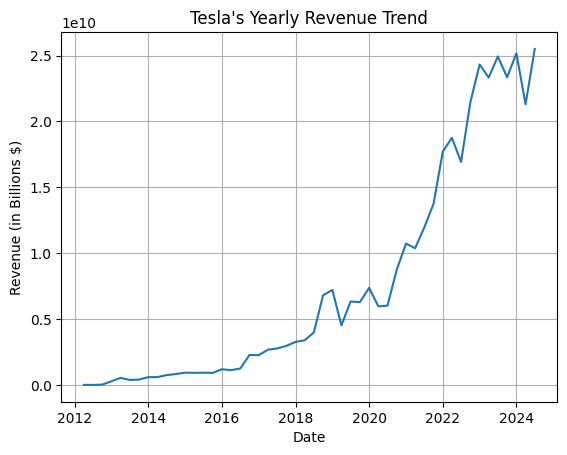

In [21]:
plt.plot(df['Date'], df['Value'])
plt.title("Tesla's Yearly Revenue Trend")
plt.xlabel('Date')
plt.ylabel('Revenue (in Billions $)')
plt.grid(True)
plt.show()

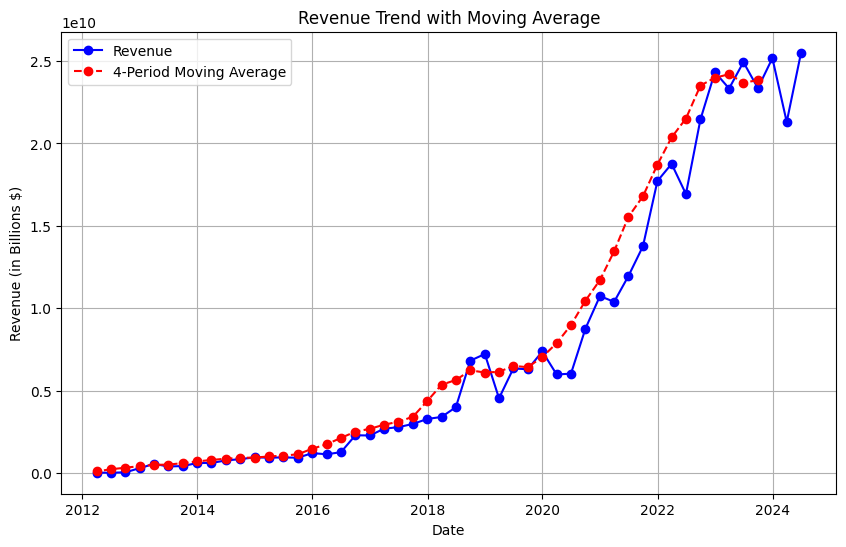

In [22]:
# We calculate the 4-period moving average in the value column
df['Value_MA'] = df['Value'].rolling(window=4).mean() 


plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Value'], marker='o', linestyle='-', label='Revenue', color='b')
plt.plot(df['Date'], df['Value_MA'], marker='o', linestyle='--', label='4-Period Moving Average', color='r')
plt.title('Revenue Trend with Moving Average')
plt.xlabel('Date')
plt.ylabel('Revenue (in Billions $)')
plt.legend()
plt.grid(True)
plt.show()

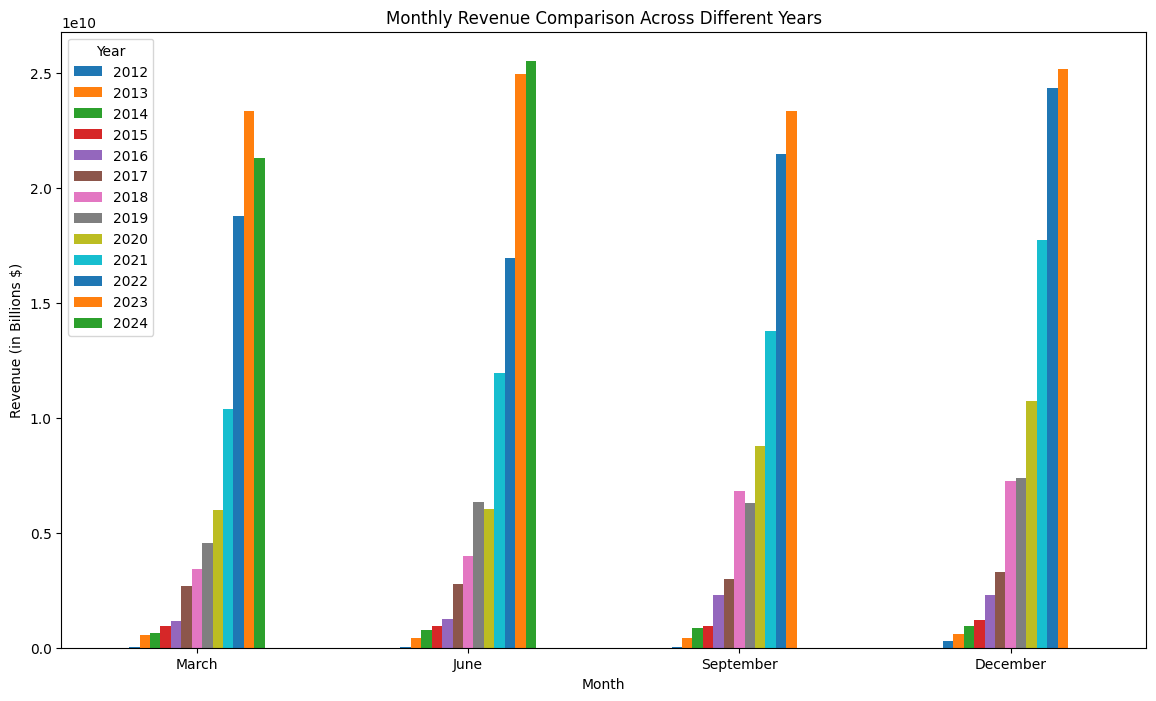

In [23]:
# We extract the month and year information from the dataframe
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%B') 

# We pivot the table to have years as columns and months as rows
pivot_df = df.pivot_table(index='Month', columns='Year', values='Value')

# We sort the pivot table by the actual month order, there is quarterly information, therefore we only need those months
month_order = [ 'March', 'June', 'September', 'December']
pivot_df = pivot_df.reindex(month_order)

# We plot the data to be analised
pivot_df.plot(kind='bar', figsize=(14, 8))
plt.title('Monthly Revenue Comparison Across Different Years')
plt.xlabel('Month')
plt.ylabel('Revenue (in Billions $)')
plt.xticks(rotation=360)
plt.legend(title='Year')
plt.show()
